In [8]:
import pandas as pd
import missingno as msno
from datetime import datetime
import numpy as np
import sklearn.compose._column_transformer
import seaborn as sns
import matplotlib.pyplot as plt

In [438]:
customers = pd.read_csv("../data/olist_customers_dataset.csv") # Client
geolocalisation = pd.read_csv("../data/olist_geolocation_dataset.csv") # Loc

order_items = pd.read_csv("../data/olist_order_items_dataset.csv") # Commandes items
order_payments = pd.read_csv("../data/olist_order_payments_dataset.csv") # Commandes paiement
order_reviews = pd.read_csv("../data/olist_order_reviews_dataset.csv") # Commandes reviews
orders = pd.read_csv("../data/olist_orders_dataset.csv") # Commandes

sellers = pd.read_csv("../data/olist_sellers_dataset.csv") # Vendeurs
products = pd.read_csv("../data/olist_products_dataset.csv") # Produits
cat_trans = pd.read_csv('../data/product_category_name_translation.csv') # Translate


In [439]:
order_cust = pd.merge(left=customers, right=orders, how="left", left_on="customer_id", right_on="customer_id")
forder_cust = pd.merge(left=order_cust, right=order_items, how="outer", left_on="order_id", right_on="order_id")

forder_cust['total'] = forder_cust[["price", "freight_value"]].sum(axis=1)

## Recence 

In [440]:
dates = ['order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date']
forder_cust[dates] =forder_cust[dates].apply(pd.to_datetime, format='%Y-%m-%d')
date_1 = forder_cust.sort_values(by ='order_approved_at',ascending = False)


recence = date_1.groupby('customer_unique_id').agg(last_date =('order_approved_at','max')).reset_index()


recence['periode']=(date_1.order_approved_at.max()-recence.last_date).dt.days
recence.dropna(inplace=True)
recence.periode = recence.periode.astype(int)

def recence_transform(row):
    if row['periode'] <= 140:
        return 1
    if row['periode']> 140 and row['periode'] <= 280:
        return 2
    if row['periode']>280 and row['periode'] <= 420:
        return 3
    if row['periode']> 420 and row['periode'] <= 560:
        return 4
    if row['periode']> 560:
        return 5 

recence['r_value']=recence.apply(lambda row: recence_transform(row),axis=1)
recence.head()

customer_unique_id           last_date  periode  r_value
0  0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 11:11:18      116        1
1  0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 18:25:44      118        1
2  0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03      541        4
3  0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:49:17      325        3
4  0004aac84e0df4da2b147fca70cf8255 2017-11-14 20:06:52      292        3

In [525]:

liste1 =cat_trans.product_category_name.tolist()
liste2 = cat_trans.product_category_name_english.tolist()
dict1 = {}
for key in liste1:
    for value in liste2:
        dict1[key] = value
        liste2.remove(value)
        break
products.product_category_name=products.product_category_name.map(dict)
order_reviews.drop(['review_comment_title','review_comment_message'],inplace=True,axis=1)
order_reviews['review_score'].dropna(inplace=True)

KeyError: "['review_comment_title', 'review_comment_message'] not found in axis"

## Merging pour l'analyse des commandes

### reajustement du df payments pour obtenir une ligne = une commande

In [95]:
def get_mode(x):
    return x.mode().iloc[0]

In [443]:
p1 = order_payments.groupby('order_id').agg(payment_installment = ('payment_installments',get_mode),payment_type = ('payment_type',get_mode),total_pay =('payment_value','sum')).reset_index()


### Merging products and order_items et les regrouper par commandes uniques

In [444]:
order_items.drop(['seller_id','price','freight_value'],inplace=True,axis=1)
products_item = pd.merge(order_items,products,how ='left',left_on='product_id',right_on='product_id')
a = products_item.groupby(['order_id','product_category_name']).agg(total_commande=('order_item_id','count'),prod =('product_id','nunique')).reset_index()
c = a.groupby('order_id').agg(category=('product_category_name',get_mode),items_commande = ('total_commande','sum'),prod_commande=('prod','sum')).reset_index()
df_commande = pd.merge(p1,c,how='left',left_on='order_id',right_on='order_id')
df_commande
#Dataframe montrant par commande , le type de paiement le plus utilisé, le total de la commande en R$, la catégorie du produit le plus commandé, le nb d'items commandé et le nombre de produits différents commandés


order_id  payment_installment payment_type  \
0      00010242fe8c5a6d1ba2dd792cb16214                    2  credit_card   
1      00018f77f2f0320c557190d7a144bdd3                    3  credit_card   
2      000229ec398224ef6ca0657da4fc703e                    5  credit_card   
3      00024acbcdf0a6daa1e931b038114c75                    2  credit_card   
4      00042b26cf59d7ce69dfabb4e55b4fd9                    3  credit_card   
...                                 ...                  ...          ...   
99435  fffc94f6ce00a00581880bf54a75a037                    1       boleto   
99436  fffcd46ef2263f404302a634eb57f7eb                    1       boleto   
99437  fffce4705a9662cd70adb13d4a31832d                    3  credit_card   
99438  fffe18544ffabc95dfada21779c9644f                    3  credit_card   
99439  fffe41c64501cc87c801fd61db3f6244                    1  credit_card   

       total_pay               category  items_commande  prod_commande  
0          72.19             cool_stuff             1.0            1.0  
1         259.83               pet_shop             1.0            1.0  
2         216.87        furniture_decor             1.0            1.0  
3          25.78              perfumery             1.0            1.0  
4         218.04           garden_tools             1.0            1.0  
...          ...                    ...             ...            ...  
99435     343.40             housewares             1.0            1.0  
99436     386.53  computers_accessories             1.0            1.0  
99437     116.85         sports_leisure             1.0            1.0  
99438      64.71  computers_accessories             1.0            1.0  
99439      55.79         bed_bath_table             1.0            1.0  

[99440 rows x 7 columns]

### Merging orders_items/products/payments

In [445]:
orders=orders.dropna()
orders[['order_purchase_timestamp','order_approved_at','order_delivered_customer_date']]= orders[['order_purchase_timestamp','order_approved_at','order_delivered_customer_date']].apply(pd.to_datetime)
orders['purchase_date']=orders.order_purchase_timestamp.dt.to_period('M')
orders['approval_time']= (orders['order_approved_at'] - orders['order_purchase_timestamp']).dt.days
orders['delivery_time'] = (orders['order_delivered_customer_date']-orders['order_purchase_timestamp']).dt.days
orders.delivery_time =orders.delivery_time.astype(int)
df_orders = orders[['order_id','customer_id','delivery_time','purchase_date']]

In [446]:
df_commande.category.nunique()

71

In [447]:
df_client = pd.merge(df_commande,df_orders,how='left',left_on='order_id',right_on='order_id')

In [448]:
df_client['months']=df_client.purchase_date.dt.month
season_dict = {1: 'Winter',
               2: 'Winter',
               3: 'Spring', 
               4: 'Spring',
               5: 'Spring',
               6: 'Summer',
               7: 'Summer',
               8: 'Summer',
               9: 'Autumn',
               10: 'Autumn',
               11: 'Autumn',
               12: 'Winter'}
df_client['Season'] = df_client['months'].map(season_dict)

In [449]:
df_client.category.nunique()

71

### REVIEW

In [450]:
df_review = order_reviews.groupby('order_id',).agg(rating = ('review_score','mean'),review = ('review_id','count')).reset_index()


### Merging df_client et df_review

In [451]:
df_merge = pd.merge(df_client,df_review,how='left',left_on='order_id',right_on='order_id')
df_merge

order_id  payment_installment payment_type  \
0      00010242fe8c5a6d1ba2dd792cb16214                    2  credit_card   
1      00018f77f2f0320c557190d7a144bdd3                    3  credit_card   
2      000229ec398224ef6ca0657da4fc703e                    5  credit_card   
3      00024acbcdf0a6daa1e931b038114c75                    2  credit_card   
4      00042b26cf59d7ce69dfabb4e55b4fd9                    3  credit_card   
...                                 ...                  ...          ...   
99435  fffc94f6ce00a00581880bf54a75a037                    1       boleto   
99436  fffcd46ef2263f404302a634eb57f7eb                    1       boleto   
99437  fffce4705a9662cd70adb13d4a31832d                    3  credit_card   
99438  fffe18544ffabc95dfada21779c9644f                    3  credit_card   
99439  fffe41c64501cc87c801fd61db3f6244                    1  credit_card   

       total_pay               category  items_commande  prod_commande  \
0          72.19             cool_stuff             1.0            1.0   
1         259.83               pet_shop             1.0            1.0   
2         216.87        furniture_decor             1.0            1.0   
3          25.78              perfumery             1.0            1.0   
4         218.04           garden_tools             1.0            1.0   
...          ...                    ...             ...            ...   
99435     343.40             housewares             1.0            1.0   
99436     386.53  computers_accessories             1.0            1.0   
99437     116.85         sports_leisure             1.0            1.0   
99438      64.71  computers_accessories             1.0            1.0   
99439      55.79         bed_bath_table             1.0            1.0   

                            customer_id  delivery_time purchase_date  months  \
0      3ce436f183e68e07877b285a838db11a            7.0       2017-09       9   
1      f6dd3ec061db4e3987629fe6b26e5cce           16.0       2017-04       4   
2      6489ae5e4333f3693df5ad4372dab6d3            7.0       2018-01       1   
3      d4eb9395c8c0431ee92fce09860c5a06            6.0       2018-08       8   
4      58dbd0b2d70206bf40e62cd34e84d795           25.0       2017-02       2   
...                                 ...            ...           ...     ...   
99435  b51593916b4b8e0d6f66f2ae24f2673d           17.0       2018-04       4   
99436  84c5d4fbaf120aae381fad077416eaa0            9.0       2018-07       7   
99437  29309aa813182aaddc9b259e31b870e6            4.0       2017-10      10   
99438  b5e6afd5a41800fdf401e0272ca74655            1.0       2017-08       8   
99439  96d649da0cc4ff33bb408b199d4c7dcf            5.0       2018-06       6   

       Season  rating  review  
0      Autumn     5.0     1.0  
1      Spring     4.0     1.0  
2      Winter     5.0     1.0  
3      Summer     4.0     1.0  
4      Winter     5.0     1.0  
...       ...     ...     ...  
99435  Spring     5.0     1.0  
99436  Summer     5.0     1.0  
99437  Autumn     5.0     1.0  
99438  Summer     5.0     1.0  
99439  Summer     5.0     1.0  

[99440 rows x 14 columns]

In [96]:
# df_merge2 = pd.merge(df_merge,customers,how='left',left_on='customer_id',right_on='customer_id')
# df_merge2.drop(['customer_id','customer_zip_code_prefix'],axis=1,inplace=True)
# df_merge2.dropna()
# df_merge2.category.fillna('None',inplace=True)
sum_list = ['total_pay','items_commande','prod_commande','review']
mod_list = ['customer_city','customer_state','category','payment_type']
last_list = ['Season','months']
mean_list = ['rating','delivery_time','payment_installment','freight_value','product_description_lenght','total_size']
count_list = ['order_id']
d1 = dict.fromkeys(sum_list, 'sum')
d2 = dict.fromkeys(mod_list, get_mode)
d3 = dict.fromkeys(max_list,'max')
d4 = dict.fromkeys(last_list,'last')
d5 = dict.fromkeys(mean_list,'mean')
d6 = dict.fromkeys(count_list,'count')
d = {**d1, **d2,**d3,**d4,**d5,**d6}

{'total_pay': ['customer_city', 'customer_state', 'category', 'payment_type'],
 'items_commande': ['customer_city',
  'customer_state',
  'category',
  'payment_type'],
 'prod_commande': ['customer_city',
  'customer_state',
  'category',
  'payment_type'],
 'review': ['customer_city', 'customer_state', 'category', 'payment_type']}

In [97]:
d

{'total_pay': 'sum',
 'items_commande': 'sum',
 'prod_commande': 'sum',
 'review': 'sum',
 'customer_city': <function __main__.get_mode(x)>,
 'customer_state': <function __main__.get_mode(x)>,
 'category': <function __main__.get_mode(x)>,
 'payment_type': <function __main__.get_mode(x)>,
 'purchase_date': 'max',
 'Season': 'last',
 'months': 'last',
 'rating': 'mean',
 'delivery_time': 'mean',
 'payment_installment': 'mean',
 'freight_value': 'mean',
 'product_description_lenght': 'mean',
 'total_size': 'mean',
 'order_id': 'count'}

In [453]:
order_items = pd.read_csv("../data/olist_order_items_dataset.csv") # Commandes items
products = pd.read_csv("../data/olist_products_dataset.csv") # Produits

In [454]:
products['total_size']=products.product_height_cm*products.product_length_cm*products.product_width_cm

jpp = pd.merge(order_items,products,how='left',left_on='product_id',right_on='product_id')
jpp = jpp.groupby('order_id').agg({'freight_value':'mean','total_size':'mean','product_description_lenght':'mean'}).reset_index()
jpp

order_id  freight_value  total_size  \
0      00010242fe8c5a6d1ba2dd792cb16214          13.29      3528.0   
1      00018f77f2f0320c557190d7a144bdd3          19.93     60000.0   
2      000229ec398224ef6ca0657da4fc703e          17.87     14157.0   
3      00024acbcdf0a6daa1e931b038114c75          12.79      2400.0   
4      00042b26cf59d7ce69dfabb4e55b4fd9          18.14     42000.0   
...                                 ...            ...         ...   
98661  fffc94f6ce00a00581880bf54a75a037          43.41     53400.0   
98662  fffcd46ef2263f404302a634eb57f7eb          36.53     44460.0   
98663  fffce4705a9662cd70adb13d4a31832d          16.95      9576.0   
98664  fffe18544ffabc95dfada21779c9644f           8.72      8000.0   
98665  fffe41c64501cc87c801fd61db3f6244          12.79      1710.0   

       product_description_lenght  
0                           598.0  
1                           239.0  
2                           695.0  
3                           480.0  
4                           409.0  
...                           ...  
98661                      1002.0  
98662                       232.0  
98663                       869.0  
98664                      1306.0  
98665                       511.0  

[98666 rows x 4 columns]

In [455]:
df_merge3 = pd.merge(df_merge2,jpp,how='left',left_on='order_id',right_on='order_id')
df_merge3

order_id  payment_installment payment_type  \
0      00010242fe8c5a6d1ba2dd792cb16214                    2  credit_card   
1      00018f77f2f0320c557190d7a144bdd3                    3  credit_card   
2      000229ec398224ef6ca0657da4fc703e                    5  credit_card   
3      00024acbcdf0a6daa1e931b038114c75                    2  credit_card   
4      00042b26cf59d7ce69dfabb4e55b4fd9                    3  credit_card   
...                                 ...                  ...          ...   
99435  fffc94f6ce00a00581880bf54a75a037                    1       boleto   
99436  fffcd46ef2263f404302a634eb57f7eb                    1       boleto   
99437  fffce4705a9662cd70adb13d4a31832d                    3  credit_card   
99438  fffe18544ffabc95dfada21779c9644f                    3  credit_card   
99439  fffe41c64501cc87c801fd61db3f6244                    1  credit_card   

       total_pay               category  items_commande  prod_commande  \
0          72.19             cool_stuff             1.0            1.0   
1         259.83               pet_shop             1.0            1.0   
2         216.87        furniture_decor             1.0            1.0   
3          25.78              perfumery             1.0            1.0   
4         218.04           garden_tools             1.0            1.0   
...          ...                    ...             ...            ...   
99435     343.40             housewares             1.0            1.0   
99436     386.53  computers_accessories             1.0            1.0   
99437     116.85         sports_leisure             1.0            1.0   
99438      64.71  computers_accessories             1.0            1.0   
99439      55.79         bed_bath_table             1.0            1.0   

       delivery_time purchase_date  months  Season  rating  review  \
0                7.0       2017-09       9  Autumn     5.0     1.0   
1               16.0       2017-04       4  Spring     4.0     1.0   
2                7.0       2018-01       1  Winter     5.0     1.0   
3                6.0       2018-08       8  Summer     4.0     1.0   
4               25.0       2017-02       2  Winter     5.0     1.0   
...              ...           ...     ...     ...     ...     ...   
99435           17.0       2018-04       4  Spring     5.0     1.0   
99436            9.0       2018-07       7  Summer     5.0     1.0   
99437            4.0       2017-10      10  Autumn     5.0     1.0   
99438            1.0       2017-08       8  Summer     5.0     1.0   
99439            5.0       2018-06       6  Summer     5.0     1.0   

                     customer_unique_id          customer_city customer_state  \
0      871766c5855e863f6eccc05f988b23cb  campos dos goytacazes             RJ   
1      eb28e67c4c0b83846050ddfb8a35d051        santa fe do sul             SP   
2      3818d81c6709e39d06b2738a8d3a2474          para de minas             MG   
3      af861d436cfc08b2c2ddefd0ba074622                atibaia             SP   
4      64b576fb70d441e8f1b2d7d446e483c5        varzea paulista             SP   
...                                 ...                    ...            ...   
99435  0c9aeda10a71f369396d0c04dce13a64               sao luis             MA   
99436  0da9fe112eae0c74d3ba1fe16de0988b               curitiba             PR   
99437  cd79b407828f02fdbba457111c38e4c4              sao paulo             SP   
99438  eb803377c9315b564bdedad672039306                vinhedo             SP   
99439  cd76a00d8e3ca5e6ab9ed9ecb6667ac4               botucatu             SP   

       freight_value  total_size  product_description_lenght  
0              13.29      3528.0                       598.0  
1              19.93     60000.0                       239.0  
2              17.87     14157.0                       695.0  
3              12.79      2400.0                       480.0  
4              18.14     42000.0                       409.0  
...              ...     

In [457]:
df_last = df_merge3.groupby('customer_unique_id').agg(d).reset_index()
rfm = pd.read_csv('data.csv')
rfm.drop(['zipcode','city','state','total','no_purchase_period'],axis=1,inplace=True)

In [458]:
df_last

customer_unique_id  total_pay  items_commande  \
0      0000366f3b9a7992bf8c76cfdf3221e2     141.90             1.0   
1      0000b849f77a49e4a4ce2b2a4ca5be3f      27.19             1.0   
2      0000f46a3911fa3c0805444483337064      86.22             1.0   
3      0000f6ccb0745a6a4b88665a16c9f078      43.62             1.0   
4      0004aac84e0df4da2b147fca70cf8255     196.89             1.0   
...                                 ...        ...             ...   
93336  fffcf5a5ff07b0908bd4e2dbc735a684    2067.42             2.0   
93337  fffea47cd6d3cc0a88bd621562a9d061      84.58             1.0   
93338  ffff371b4d645b6ecea244b27531430a     112.46             1.0   
93339  ffff5962728ec6157033ef9805bacc48     133.69             1.0   
93340  ffffd2657e2aad2907e67c3e9daecbeb      71.56             1.0   

       prod_commande  review       customer_city customer_state  \
0                1.0     1.0             cajamar             SP   
1                1.0     1.0              osasco             SP   
2                1.0     1.0            sao jose             SC   
3                1.0     1.0               belem             PA   
4                1.0     1.0            sorocaba             SP   
...              ...     ...                 ...            ...   
93336            2.0     1.0             sanharo             PE   
93337            1.0     1.0    feira de santana             BA   
93338            1.0     1.0               sinop             MT   
93339            1.0     1.0  bom jesus do norte             ES   
93340            1.0     1.0         campo largo             PR   

             category payment_type purchase_date  Season  months  rating  \
0      bed_bath_table  credit_card       2018-05  Spring       5     5.0   
1       health_beauty  credit_card       2018-05  Spring       5     4.0   
2          stationery  credit_card       2017-03  Spring       3     3.0   
3           telephony  credit_card       2017-10  Autumn      10     4.0   
4           telephony  credit_card       2017-11  Autumn      11     5.0   
...               ...          ...           ...     ...     ...     ...   
93336   health_beauty  credit_card       2017-06  Summer       6     5.0   
93337            baby  credit_card       2017-12  Winter      12     4.0   
93338            auto  credit_card       2017-02  Winter       2     5.0   
93339   watches_gifts  credit_card       2018-05  Spring       5     5.0   
93340       perfumery  credit_card       2017-05  Spring       5     5.0   

       delivery_time  payment_installment  freight_value  \
0                6.0                  8.0          12.00   
1                3.0                  1.0           8.29   
2               25.0                  8.0          17.22   
3               20.0                  4.0          17.63   
4               13.0                  6.0          16.89   
...              ...                  ...            ...   
93336           27.0                 10.0         248.71   
93337           30.0                  1.0          19.69   
93338           14.0                  1.0          22.56   
93339           11.0                  5.0          18.69   
93340            7.0                  4.0          14.57   

       product_description_lenght  total_size  order_id  
0                           236.0      7616.0         1  
1                           635.0      5148.0         1  
2                           177.0     43750.0         1  
3                          1741.0      1045.0         1  
4                           794.0       528.0         1  
...                           ...         ...       ...  
93336                       478.5    251625.0         1  
93337                       506.0     32076.0         1  
93338                       716.0      3315.0         1  
93339                       591.0      4480.0         1  
93340                      1003.0      2178.0         1  

[93341 rows x 19 columns]

In [459]:
df = pd.merge(df_last,rfm,how='left',left_on='customer_unique_id',right_on = 'id')
df.drop(['id','last_purchase','customer_unique_id'],axis=1,inplace=True)
df.dropna(how = 'any',inplace=True)

In [460]:
transformer = {'Meubles et décoration': ['bed_bath_table','furniture_decor','office_furniture','home_comfort_2','home_confort', 'housewares', 'furniture_living_room','kitchen_dining_laundry_garden_furniture', 'furniture_bedroom','furniture_mattress_and_upholstery'],
                'Électronique et informatique': ['audio','fixed_telephony','telephony', 'computers_accessories', 'electronics', 'consoles_games', 'computers', 'signaling_and_security','tablets_printing_image', 'cds_dvds_musicals', 'dvds_blu_ray', 'music'],
                'Santé et beauté': ['health_beauty', 'perfumery'],
                'Mode et accessoires': ['fashion_bags_accessories', 'fashion_underwear_beach', 'fashion_shoes', 'fashion_male_clothing', 'fashion_sport', 'luggage_accessories','fashio_female_clothing', 'fashion_childrens_clothes'],
                'Petits appareils ménagers': ['home_appliances','home_appliances_2','small_appliances', 'small_appliances_home_oven_and_coffee', 'air_conditioning'],
                'Outils et matériaux de construction': ['construction_tools_construction','construction_tools_safety','construction_tools_construction,' 'construction_tools_safety', 'construction_tools_lights', 'costruction_tools_garden', 'costruction_tools_tools','home_construction'],
                'Loisirs et sports':['sports_leisure', 'garden_tools', 'musical_instruments', 'cool_stuff', 'toys', 'books_general_interest', 'books_technical', 'books_imported', 'cine_photo', 'art', 'arts_and_craftmanship'],
                'Autres': ['stationery',  'watches_gifts', 'auto', 'christmas_supplies', 'drinks','baby', 'pet_shop', 'market_place', 'flowers', 'industry_commerce_and_business', 'food_drink', 'food', 'agro_industry_and_commerce', 'party_supplies', 'diapers_and_hygiene', 'security_and_services','la_cuisine'],
                'Inconnu' : ['None']
}        
keys =transformer.keys()
for key in keys:
  df.category = df.category.replace(to_replace=transformer[key], value=key)


In [461]:
df.columns =['total_pay', 'nb_total_items_commande', 'nb_prod_different', 'nb_review',
       'customer_city', 'customer_state', 'category', 'payment_type','purchase_date','Season',
       'months', 'rating_review', 'delivery_time', 'payment_installment',
       'freight_value', 'product_description_lenght', 'total_size', 'nb_total_commande',
       'freq', 'recense', 'montant']

In [462]:
df['panier_moyen']=df['total_pay']/df['nb_total_commande']
df.drop(['customer_city','customer_state'],axis=1,inplace=True)


### TESST

In [9]:
merged = pd.read_csv('merged.csv')
df = merged.copy()
df.recense = df.recense +3
df.freq = df.freq +3 


In [10]:
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,FunctionTransformer,StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px
from kmodes.kprototypes import KPrototypes

## Clustering 2017

In [11]:
df.sort_values('purchase_date',ascending=False,inplace=True)
df['Year']=df.purchase_date.astype(str).str[0:4]

In [12]:
df_2017 = df[df.Year=='2017'].drop(['purchase_date','months','Year','nb_prod_different','nb_review','nb_total_items_commande','nb_total_commande','panier_moyen'],axis=1)
df_2017_index = df_2017.index.tolist()

In [13]:
df_2017

total_pay                      category payment_type  Season  \
44802     120.90               Santé et beauté  credit_card  Winter   
45210      32.77  Électronique et informatique       boleto  Winter   
4321       73.66                        Autres  credit_card  Winter   
15663     143.01                        Autres       boleto  Winter   
76716      56.00  Électronique et informatique  credit_card  Winter   
...          ...                           ...          ...     ...   
16602     350.97             Loisirs et sports       boleto  Winter   
24214     146.01             Loisirs et sports  credit_card  Winter   
26020      60.10         Meubles et décoration  credit_card  Winter   
6722       33.95  Électronique et informatique       boleto  Winter   
16712     164.21                        Autres  credit_card  Winter   

       rating_review  delivery_time  payment_installment  freight_value  \
44802            5.0           13.0                  1.0      35.910000   
45210            5.0            4.0                  1.0       7.780000   
4321             3.0           18.0                  2.0      15.160000   
15663            5.0           19.0                  1.0      26.100000   
76716            1.0           21.0                  1.0      15.100000   
...              ...            ...                  ...            ...   
16602            5.0           11.0                  1.0      16.138889   
24214            2.0           10.0                 10.0      16.020000   
26020            1.0           40.0                  6.0      15.110000   
6722             4.0            5.0                  1.0      10.960000   
16712            5.0            9.0                  3.0      15.210000   

       product_description_lenght  total_size  freq  recense  montant  
44802                 1495.000000      8151.0     3      3.0        2  
45210                  777.000000       816.0     3      3.0        1  
4321                   309.000000      1071.0     3      3.0        1  
15663                  138.000000      4050.0     3      3.0        3  
76716                  401.000000      4862.0     3      3.0        1  
...                           ...         ...   ...      ...      ...  
16602                  670.666667      7013.0     3      3.0        7  
24214                 2751.000000     13020.0     3      3.0        3  
26020                  829.000000      5984.0     3      3.0        1  
6722                   267.000000       627.0     3      3.0        1  
16712                  748.000000      2704.0     3      3.0        3  

[40466 rows x 13 columns]

In [14]:
def log(x):
    return np.log1p(abs(x))
transformer = FunctionTransformer(log)
transformer2 = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    (transformer,make_column_selector(dtype_include=np.number))
    )

In [15]:
new_columns = df_2017.select_dtypes(np.number).columns.tolist()+df_2017.select_dtypes(object).columns.to_list()
scaler = make_column_transformer((transformer,make_column_selector(dtype_include=np.number)),
remainder='passthrough'
)
normalize =make_column_transformer((StandardScaler(),make_column_selector(dtype_include=np.number)),
remainder='passthrough'
)




In [16]:
df_t = scaler.fit_transform(df_2017)
test = pd.DataFrame(df_t,columns=new_columns)
df_test =normalize.fit_transform(test)

In [17]:
k = 4
df_test =normalize.fit_transform(test)
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters = model.fit_predict(df_t, categorical=[10,11,12])


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 5, iteration: 1/50, moves: 11193, ncost: 106937.7244294238
Run: 4, iteration: 1/50, moves: 11532, ncost: 114057.48231800416
Run: 1, iteration: 1/50, moves: 15267, ncost: 110579.40860398747
Run: 3, iteration: 1/50, moves: 11086, ncost: 114094.5386541121
Run: 2, iteration: 1/50, moves: 9486, ncost: 112571.80827352797
Run: 4, iteration: 2/50, moves: 6010, ncost: 111504.76624661678
Run: 1, iteration: 2/50, moves: 5487, ncost: 108183.95779248342
Run: 5, iteration: 2/50, moves: 3181, ncost: 106389.76670323778
Run: 2, it

In [18]:
clusters_list = []
for c in clusters:
    clusters_list.append(c)

In [19]:
df_2017['clusters']= clusters_list

## CLUSTERING 2017 N+3


In [20]:
df.purchase_date = pd.to_datetime(df.purchase_date)


In [21]:
df_2017_n3 = df[(df.purchase_date >= '2017') & (df.purchase_date <= '2018-03')].drop(['purchase_date','months','months','Year','nb_prod_different','nb_review','nb_total_items_commande','nb_total_commande','panier_moyen'],axis=1)

In [22]:
new_columns = df_2017_n3.select_dtypes(np.number).columns.tolist()+df_2017_n3.select_dtypes(object).columns.to_list()
scaler = make_column_transformer((transformer,make_column_selector(dtype_include=np.number)),
remainder='passthrough'
)
normalize =make_column_transformer((StandardScaler(),make_column_selector(dtype_include=np.number)),
remainder='passthrough'
)
df_t2 = scaler.fit_transform(df_2017_n3)
test = pd.DataFrame(df_t2,columns=new_columns)

In [23]:
df_test =normalize.fit_transform(test)
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters_n3 = model.fit_predict(df_t2, categorical=[10,11,12])
clusters_list_n3 = []
for c in clusters_n3:
    clusters_list_n3.append(c)


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 5, iteration: 1/50, moves: 17428, ncost: 171856.8828583792
Run: 3, iteration: 1/50, moves: 16778, ncost: 182640.74132068348
Run: 4, iteration: 1/50, moves: 16796, ncost: 183532.41446281192
Run: 1, iteration: 1/50, moves: 23300, ncost: 178827.59114746194
Run: 2, iteration: 1/50, moves: 14239, ncost: 179732.49686245585
Run: 5, iteration: 2/50, moves: 4928, ncost: 170982.6458035469
Run: 3, iteration: 2/50, moves: 6714, ncost: 179281.29552360272
Run: 4, iteration: 2/50, moves: 8729, ncost: 179658.02561283592
Run: 2, i

In [24]:
df_2017_n3['clusters']= clusters_list_n3

## Clustering 2017 n+6

In [25]:
df_2017_n6 = df[(df.purchase_date >= '2017') & (df.purchase_date <= '2018-06')].drop(['purchase_date','months','months','Year','nb_prod_different','nb_review','nb_total_items_commande','nb_total_commande','panier_moyen'],axis=1)

In [26]:
df_t3 = scaler.fit_transform(df_2017_n6)
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters_n6 = model.fit_predict(df_t3, categorical=[10,11,12])
clusters_list_n6 = []
for c in clusters_n6:
    clusters_list_n6.append(c)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 3, iteration: 1/50, moves: 21875, ncost: 253468.95136549024
Run: 2, iteration: 1/50, moves: 18942, ncost: 249487.30167952267
Run: 1, iteration: 1/50, moves: 30863, ncost: 243632.76872537142
Run: 5, iteration: 1/50, moves: 23520, ncost: 238306.10164076567
Run: 4, iteration: 1/50, moves: 22532, ncost: 255353.76007354612
Run: 3, iteration: 2/50, moves: 8940, ncost: 248830.15647892293
Run: 2, iteration: 2/50, moves: 10658, ncost: 241254.525061087
Run: 5, iteration: 2/50, moves: 6173, ncost: 237251.85590360794
Run: 1, 

In [27]:
df_2017_n6['clusters']=clusters_list_n6

## Clustering n+9

In [28]:
df_2017_n9 = df[(df.purchase_date >= '2017') & (df.purchase_date <= '2018-09')].drop(['purchase_date','months','months','Year','nb_prod_different','nb_review','nb_total_items_commande','nb_total_commande','panier_moyen'],axis=1)

In [29]:
df_t4 = scaler.fit_transform(df_2017_n9)
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters_n9 = model.fit_predict(df_t4, categorical=[10,11,12])
clusters_list_n9 = []
for c in clusters_n9:
    clusters_list_n9.append(c)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 3, iteration: 1/50, moves: 25009, ncost: 301061.17764310946
Run: 4, iteration: 1/50, moves: 26761, ncost: 302613.44752441935
Run: 2, iteration: 1/50, moves: 22063, ncost: 295706.3671954382
Run: 5, iteration: 1/50, moves: 26915, ncost: 282959.41044980043
Run: 1, iteration: 1/50, moves: 36238, ncost: 288915.59529170446
Run: 3, iteration: 2/50, moves: 10624, ncost: 295894.5274402852
Run: 2, iteration: 2/50, moves: 12224, ncost: 286680.93940241175
Run: 4, iteration: 2/50, moves: 13134, ncost: 296797.11131872534
Run: 5

In [30]:
df_2017_n9['clusters']=clusters_list_n9

## Clustering 2018

In [31]:
df_2018 = df[(df.purchase_date >= '2017') & (df.purchase_date < '2019')].drop(['purchase_date','months','months','Year','nb_prod_different','nb_review','nb_total_items_commande','nb_total_commande','panier_moyen'],axis=1)

In [32]:
df_t5 = scaler.fit_transform(df_2018)
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters_2018 = model.fit_predict(df_t5, categorical=[10,11,12])
clusters_list_2018 = []
for c in clusters_2018:
    clusters_list_2018.append(c)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 2, iteration: 1/50, moves: 22063, ncost: 295706.3671954382
Run: 4, iteration: 1/50, moves: 26761, ncost: 302613.44752441935
Run: 3, iteration: 1/50, moves: 25009, ncost: 301061.17764310946
Run: 5, iteration: 1/50, moves: 26915, ncost: 282959.41044980043
Run: 1, iteration: 1/50, moves: 36238, ncost: 288915.59529170446
Run: 2, iteration: 2/50, moves: 12224, ncost: 286680.93940241175
Run: 5, iteration: 2/50, moves: 7407, ncost: 281834.32494400063
Run: 4, iteration: 2/50, moves: 13134, ncost: 296797.11131872534
Run: 3

In [33]:
df_2018['clusters']=clusters_list_2018

## ARI SCORE

In [34]:
from sklearn.metrics.cluster import rand_score

In [35]:
t0 = df_2017.clusters.tolist()
t1 =df_2017_n3.clusters.loc[df_2017_index].tolist()
t2=df_2017_n6.clusters.loc[df_2017_index].tolist()
t3 = df_2017_n9.clusters.loc[df_2017_index].tolist()
t4=df_2018.clusters.loc[df_2017_index].tolist()

In [36]:
df_ari = pd.DataFrame(
    {   't0':t0,
        't1':t1,
        't2':t2,
        't3':t3,
        't4':t4
    }
)
ari_list = []

In [37]:
for elt in df_ari.columns:
    if elt == 't0':
        print("ok")
    else:
        ari = rand_score(df_ari.t0,df_ari[elt])
        ari_list.append(ari)

ok


In [38]:
ari_list

[0.9746962773103941,
 0.9498354548846113,
 0.9367794930808215,
 0.9367794930808215]

In [39]:
ari_keys = ['3','6','9','12']
ari_dict = {k: v for k, v in zip(ari_keys, ari_list)}

In [40]:
ari_dict

{'3': 0.9746962773103941,
 '6': 0.9498354548846113,
 '9': 0.9367794930808215,
 '12': 0.9367794930808215}

<AxesSubplot:>

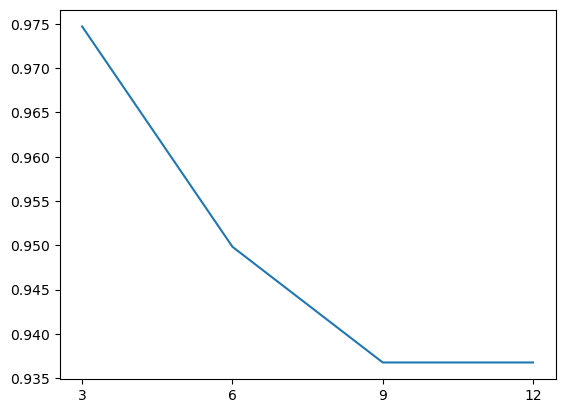

In [41]:
sns.lineplot(ari_dict)

## PCA

In [42]:
df_full = df.drop(['purchase_date','months','months','Year','nb_prod_different','nb_review','nb_total_items_commande','nb_total_commande','panier_moyen'],axis=1)

In [43]:
df_ft = scaler.fit_transform(df_full)
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters_2018 = model.fit_predict(df_ft, categorical=[10,11,12])
clusters_list_2018 = []
for c in clusters_2018:
    clusters_list_2018.append(c)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 4, iteration: 1/50, moves: 26815, ncost: 303545.1906158004
Run: 2, iteration: 1/50, moves: 22156, ncost: 296655.9423187437
Run: 3, iteration: 1/50, moves: 25060, ncost: 301988.2910347888
Run: 1, iteration: 1/50, moves: 36335, ncost: 289822.42824364675
Run: 5, iteration: 1/50, moves: 26998, ncost: 283846.17078305373
Run: 1, iteration: 2/50, moves: 11512, ncost: 285682.96511376544
Run: 4, iteration: 2/50, moves: 13171, ncost: 297700.4766513302
Run: 3, iteration: 2/50, moves: 10638, ncost: 296803.63784088404
Run: 2, 

In [44]:
# preprocessing = make_pipeline(transformer2,MinMaxScaler())
pca = make_pipeline(transformer2,PCA(n_components=0.95))
components = pca.fit_transform(df_full)
df_pca = pd.DataFrame(components)
df_pca['cluster'] = clusters_list_2018


<AxesSubplot:xlabel='0', ylabel='1'>

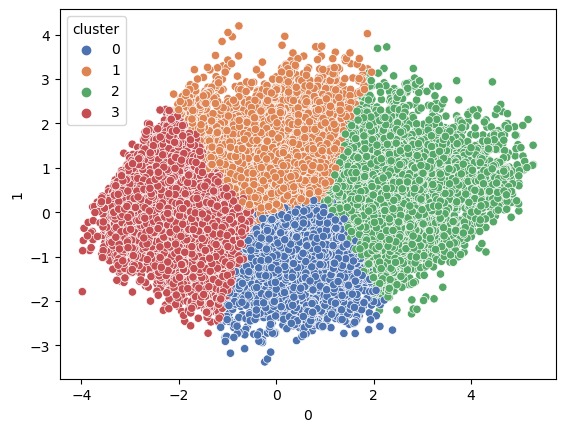

In [45]:
sns.scatterplot(data=df_pca,x=df_pca.iloc[:,0],y=df_pca.iloc[:,1],hue='cluster',palette='deep')

In [46]:
graph = components[:, 0:2]


loadings = graph

fig = px.scatter(graph, x=0, y=1, color=df_pca['cluster'])

for i, feature in enumerate(new_columns):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()


## Analyse

In [47]:
# fig, ax =plt.subplots(4,3,figsize=(20,18))
# plt.suptitle("Distribution des variables dans notre jeu de donnée",fontsize =20)
# n=0
# p=0
# for name in df_full.columns.tolist():
#     sns.histplot(ax=ax[n,p],x=name,data=df)
#     if p ==0 or p%2!=0:
#         p+=1
#     elif p == 2 :
#         p=0
#         n+=1

In [48]:
mms = MinMaxScaler(feature_range =(1,5))

In [49]:
clusters_means = df_full.select_dtypes(np.number)
cmn= clusters_means.columns.tolist()

In [50]:
# df_clusters = pd.DataFrame(mms.fit_transform(clusters_means),columns =cmn)
# df_clusters['clusters']=clusters_list_2018
# df_clusters= df_clusters.groupby('clusters').agg('mean')

In [51]:
df_clusters_test = clusters_means.copy()
df_clusters_test['clusters']=clusters_list_2018
df_clusters_test = df_clusters_test.groupby('clusters').agg('mean')
df_clusters_test[cmn]=mms.fit_transform(df_clusters_test[cmn])

In [52]:
df_clusters_test

total_pay  rating_review  delivery_time  payment_installment  \
clusters                                                                 
0           1.50416       4.594030       1.808485             1.894965   
1           3.12987       2.865514       3.855983             3.647376   
2           5.00000       1.000000       5.000000             5.000000   
3           1.00000       5.000000       1.000000             1.000000   

          freight_value  product_description_lenght  total_size      freq  \
clusters                                                                    
0              1.493553                    1.000000    2.361447  1.000000   
1              2.050512                    5.000000    1.224712  5.000000   
2              5.000000                    3.548079    5.000000  3.869254   
3              1.000000                    1.479897    1.000000  2.137081   

           recense   montant  
clusters                      
0         1.000000  1.659121  
1         5.000000  3.538685  
2         2.126502  5.000000  
3         4.199311  1.000000

In [53]:
import plotly.graph_objects as go

In [54]:
# Créer une figure en radar pour chaque cluster
fig = go.Figure()

for cluster, row in df_clusters_test.iterrows():
    values = row.values.tolist()
    

    

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=cmn,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

# Mettre en forme la figurenum_cols,
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
    ),
    showlegend=True,
    width=780,
    height=780

)

# Afficher la figure
fig.show()
figsize = (60,60)

In [77]:
df_category = pd.get_dummies(df_full.category)
df_category

Autres  Inconnu  Loisirs et sports  Meubles et décoration  \
24590       1        0                  0                      0   
65049       1        0                  0                      0   
44869       0        0                  0                      0   
32431       0        0                  1                      0   
49475       1        0                  0                      0   
...       ...      ...                ...                    ...   
89606       0        0                  0                      0   
63888       0        0                  1                      0   
27160       0        0                  0                      0   
79586       0        0                  0                      0   
85400       0        0                  0                      1   

       Mode et accessoires  Outils et matériaux de construction  \
24590                    0                                    0   
65049                    0                                    0   
44869                    0                                    0   
32431                    0                                    0   
49475                    0                                    0   
...                    ...                                  ...   
89606                    0                                    0   
63888                    0                                    0   
27160                    0                                    0   
79586                    0                                    0   
85400                    0                                    0   

       Petits appareils ménagers  Santé et beauté  \
24590                          0                0   
65049                          0                0   
44869                          1                0   
32431                          0                0   
49475                          0                0   
...                          ...              ...   
89606                          0                1   
63888                          0                0   
27160                          0                0   
79586                          0                1   
85400                          0                0   

       Électronique et informatique  
24590                             0  
65049                             0  
44869                             0  
32431                             0  
49475                             0  
...                             ...  
89606                             0  
63888                             0  
27160                             1  
79586                             0  
85400                             0  

[91484 rows x 9 columns]

In [78]:
cmc = df_category.columns.to_list()

In [79]:
df_category['cluster']=clusters_list_2018

In [80]:
df_catego=    df_category.groupby('cluster').agg('mean')
df_catego[cmc] = mms.fit_transform(df_catego[cmc])
df_catego

Autres   Inconnu  Loisirs et sports  Meubles et décoration  \
cluster                                                                 
0        1.000000  1.434364           5.000000               5.000000   
1        5.000000  4.493016           2.601938               1.000000   
2        2.345645  5.000000           4.016675               4.666426   
3        2.491644  1.000000           1.000000               1.472764   

         Mode et accessoires  Outils et matériaux de construction  \
cluster                                                             
0                   2.430561                             1.313302   
1                   1.000000                             3.994777   
2                   2.757559                             5.000000   
3                   5.000000                             1.000000   

         Petits appareils ménagers  Santé et beauté  \
cluster                                               
0                         1.800855         1.145255   
1                         1.000000         5.000000   
2                         5.000000         1.000000   
3                         1.587642         2.696440   

         Électronique et informatique  
cluster                                
0                            1.000000  
1                            2.825121  
2                            1.071650  
3                            5.000000

In [82]:
# Créer une figure en radar pour chaque cluster
fig = go.Figure()

for cluster, row in df_catego.iterrows():
    values = row.values.tolist()
    

    

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=cmc,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

# Mettre en forme la figurenum_cols,
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
    ),
    showlegend=True,
    width=780,
    height=780

)

# Afficher la figure
fig.show()
figsize = (60,60)

In [55]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

In [56]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    (MinMaxScaler(),make_column_selector(dtype_include=np.number))
    )


df = transformer.fit_transform(df)
df=pd.DataFrame(df)




Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8a31649000>
Traceback (most recent call last):
  File "/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thread

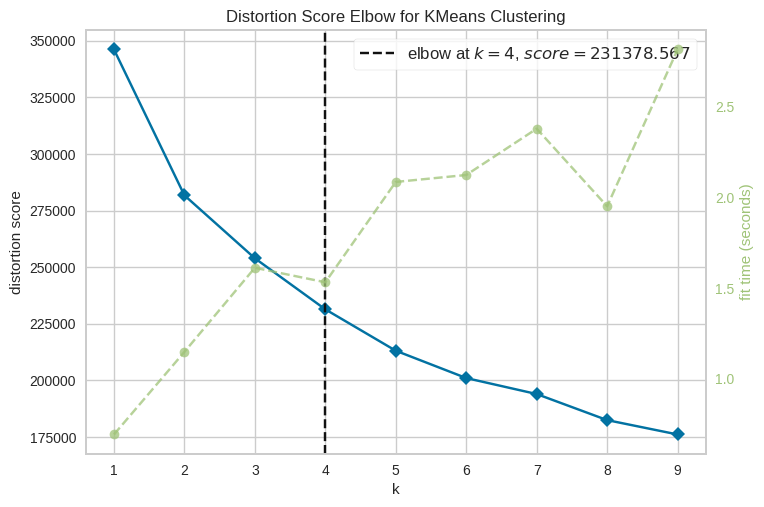

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [57]:
visualizer = KElbowVisualizer(KMeans(), k=(1,10))

visualizer.fit(df)  # Fit the data to the visualizer
visualizer.show() 

In [83]:
df = pd.read_csv('merged.csv')


pip install pandas 
pip install missingno
conda install pandas
conda install -c conda-forge missingno

In [ ]:
import pandas as pd 
import missingno as msno 

In [ ]:
#lire un fichier csv

df = pd.read_csv('fichiercsv')
#importer le csv sans les index 
df.to_csv('ficheiercsv', index = False) 


In [84]:
df.info() # afficher le type des colonnes présentes sur notre dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91484 entries, 0 to 91483
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   total_pay                   91484 non-null  float64
 1   nb_total_items_commande     91484 non-null  float64
 2   nb_prod_different           91484 non-null  float64
 3   nb_review                   91484 non-null  float64
 4   category                    91484 non-null  object 
 5   payment_type                91484 non-null  object 
 6   purchase_date               91484 non-null  object 
 7   Season                      91484 non-null  object 
 8   months                      91484 non-null  int64  
 9   rating_review               91484 non-null  float64
 10  delivery_time               91484 non-null  float64
 11  payment_installment         91484 non-null  float64
 12  freight_value               91484 non-null  float64
 13  product_description_lenght  914

In [85]:
df.describe() #Permet d'obtenir la moyenne,les quartiles,l'écart type,le nombre de variables présentes dans la colonne, le minimum et le maximum des colonnes numériques

total_pay  nb_total_items_commande  nb_prod_different     nb_review  \
count  91484.000000             91484.000000       91484.000000  91484.000000   
mean     165.183979                 1.178851           1.072417      1.039329   
std      224.998988                 0.616034           0.326482      0.250934   
min        9.590000                 0.000000           0.000000      1.000000   
25%       63.100000                 1.000000           1.000000      1.000000   
50%      107.780000                 1.000000           1.000000      1.000000   
75%      182.940000                 1.000000           1.000000      1.000000   
max    13664.080000                24.000000          14.000000     15.000000   

             months  rating_review  delivery_time  payment_installment  \
count  91484.000000   91484.000000   91484.000000         91484.000000   
mean       6.037198       4.154700      12.058463             2.888076   
std        3.218944       1.278915       9.458758             2.679239   
min        1.000000       1.000000       0.000000             0.000000   
25%        3.000000       4.000000       6.000000             1.000000   
50%        6.000000       5.000000      10.000000             2.000000   
75%        8.000000       5.000000      15.000000             4.000000   
max       12.000000       5.000000     208.000000            24.000000   

       freight_value  product_description_lenght     total_size  \
count   91484.000000                91484.000000   91484.000000   
mean       20.214766                  795.332485   15199.488811   
std        15.728958                  649.815041   23122.020972   
min         0.000000                    4.000000     168.000000   
25%        13.370000                  354.000000    2856.000000   
50%        16.430000                  611.000000    6600.000000   
75%        21.220000                  998.000000   18375.000000   
max       409.680000                 3992.000000  296208.000000   

       nb_total_commande          freq       recense       montant  \
count       91484.000000  91484.000000  91484.000000  91484.000000   
mean            1.033940      1.983658      3.194165      2.928665   
std             0.210811      2.289142      3.494204      2.385945   
min             1.000000      0.000000      0.000000      0.000000   
25%             1.000000      0.000000      0.000000      1.000000   
50%             1.000000      3.000000      3.000000      2.000000   
75%             1.000000      3.000000      6.000000      4.000000   
max            15.000000     72.000000     10.000000     10.000000   

       panier_moyen  
count  91484.000000  
mean     160.236249  
std      218.121993  
min        9.590000  
25%       62.407500  
50%      105.380000  
75%      176.900000  
max    13664.080000

In [87]:
df.columns

Index(['total_pay', 'nb_total_items_commande', 'nb_prod_different',
       'nb_review', 'category', 'payment_type', 'purchase_date', 'Season',
       'months', 'rating_review', 'delivery_time', 'payment_installment',
       'freight_value', 'product_description_lenght', 'total_size',
       'nb_total_commande', 'freq', 'recense', 'montant', 'panier_moyen'],
      dtype='object')

In [88]:
df.payment_type ou df['payment_type']

0        credit_card
1        credit_card
2        credit_card
3        credit_card
4        credit_card
            ...     
91479    credit_card
91480    credit_card
91481    credit_card
91482    credit_card
91483    credit_card
Name: payment_type, Length: 91484, dtype: object

In [93]:
df.freq.values_count()

AttributeError: 'Series' object has no attribute 'values_count'